In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing

import azureml.core
from azureml.core import Dataset
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

In [114]:
# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

# Initialise workspace
ws = Workspace.from_config(auth=interactive_auth)

# Data import 
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()
data.set_index('CardHolder', inplace=True)

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


# 1. Outliers

In [123]:
# Any group number is in diaposon from 20 to 79
all_groups = [i for i in range(20, 80)]

# This function returns columns from 'columns' list, which are met in columns of "data"
def get_columns_list(data, columns):
    return data.columns[data.columns.isin(columns)]

Соберем интересующие нас признаки: некоторые уже есть в датасете, некоторые придется собирать.

In [132]:
# Name of a feature : (columns to collect from, method)
# methods : mean, max, min, sum
collect_features = {
    'cheque_count_12m_max'             : (get_columns_list(data, ['cheque_count_12m_g{}'.format(i) for i in all_groups]), 'sum'),
    'children'                         : (['children'], 'max'),
    'crazy_purchases_cheque_count_12m' : (['crazy_purchases_cheque_count_12m'], 'max'),
    'k_var_disc_share_6m_max'          : (get_columns_list(data, ['k_var_disc_share_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'k_var_sku_price_6m_max'           : (get_columns_list(data, ['k_var_sku_price_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'sale_sum_12m_sum'                  : (get_columns_list(data, ['sale_sum_6m_g{}'.format(i) for i in all_groups]), 'sum'),
}

In [133]:
for key in collect_features.keys():
    method = collect_features[key][1]
    
    if method == 'max':
        data.loc[:, key] = data[collect_features[key][0]].max(axis=1)
    elif method == 'sum':
        data.loc[:, key] = data[collect_features[key][0]].sum(axis=1)
    elif method == 'max':
        data.loc[:, key] = data[collect_features[key][0]].max(axis=1)
    elif method == 'min':
        data.loc[:, key] = data[collect_features[key][0]].min(axis=1)

По собранным признакам посмотрим на значения-выбросы, которые опредялетются по разным пропорциям (whis) относительно IQR. Полученные записи разделим на записи из тестовой и контрольной групп и их разделим по участию в акции. Посмотрим на пропорции.

Column cheque_count_12m_max
        Type  whis1.5   whis2  whis2.5   whis3
0     test_0   432047  440669   446363  450331
1     test_1    41853   45024    47506   49516
2  control_0   144816  147624   149541  150787
3  control_1    12905   13940    14704   15318


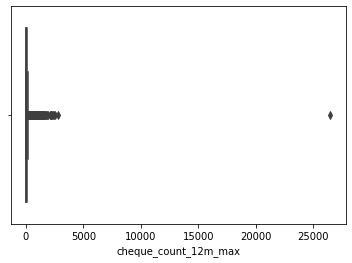

Column children
        Type  whis1.5   whis2  whis2.5   whis3
0     test_0   436922  453304   453304  453650
1     test_1    53728   55595    55595   55639
2  control_0   146257  151684   151684  151811
3  control_1    16604   17185    17185   17198


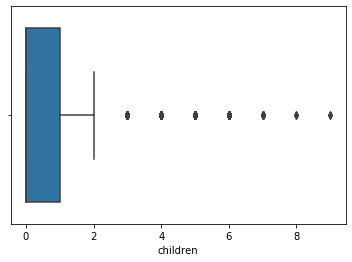

Column crazy_purchases_cheque_count_12m
        Type  whis1.5   whis2  whis2.5   whis3
0     test_0   428149  438737   442364  447457
1     test_1    43475   46811    48116   50164
2  control_0   143750  147196   148333  149976
3  control_1    13620   14654    15050   15635


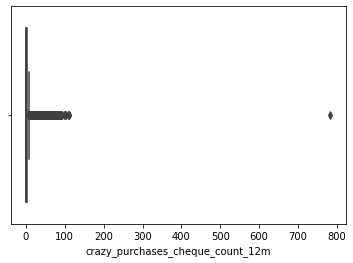

Column k_var_disc_share_6m_max
        Type  whis1.5   whis2  whis2.5   whis3
0     test_0   455755  455989   456137  456205
1     test_1    56391   56477    56552   56603
2  control_0   152503  152582   152618  152653
3  control_1    17423   17457    17480   17493


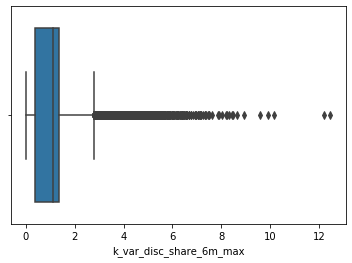

Column k_var_sku_price_6m_max
        Type  whis1.5   whis2  whis2.5   whis3
0     test_0   455562  456428   456621  456666
1     test_1    56138   56613    56732   56763
2  control_0   152395  152719   152785  152802
3  control_1    17356   17487    17523   17535


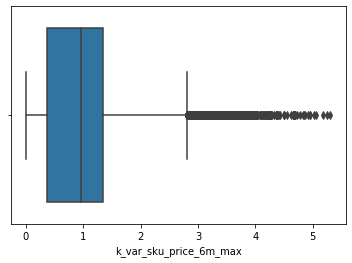

Column sale_sum_12m_sum
        Type  whis1.5   whis2  whis2.5   whis3
0     test_0   426160  434636   440692  444971
1     test_1    41194   44137    46519   48334
2  control_0   142905  145788   147717  149069
3  control_1    12724   13618    14312   14889


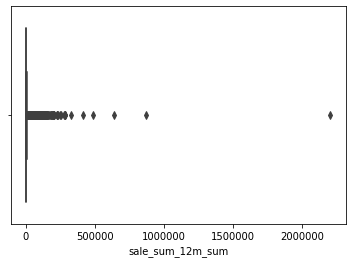

In [136]:
for key in collect_features.keys():
    print('Column', key)
    
    dataframe = {'Type' : ['test_0', 'test_1', 'control_0', 'control_1']}
    for whis in [1.5, 2, 2.5, 3]:
        IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
        sample = data[data[key] <= data[key].quantile(0.75) + IQR * whis]
        sample_test = sample[sample['group'] == 'test']['response_att'].value_counts()
        sample_control = sample[sample['group'] == 'control']['response_att'].value_counts()
        
        dataframe['whis{}'.format(whis)] = [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
    
    print(pd.DataFrame(dataframe))
    sns.boxplot(data[key])
    plt.show()

Column cheque_count_12m_max
        Type  whis1.5  whis2  whis2.5  whis3
0     test_0    23195  14848    10323   6791
1     test_1    14509  11063     8767   6697
2  control_0     7592   4871     3375   2210
3  control_1     4486   3410     2747   2099


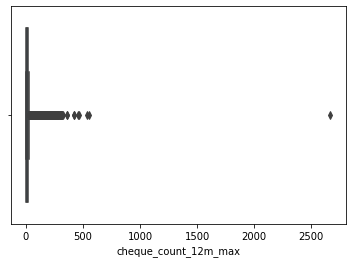

Column children
        Type  whis1.5  whis2  whis2.5  whis3
0     test_0    16817    435      435     89
1     test_1     1930     63       63     19
2  control_0     5592    165      165     38
3  control_1      598     17       17      4


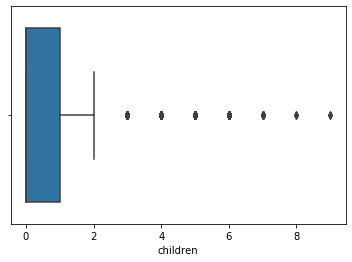

Column crazy_purchases_cheque_count_12m
        Type  whis1.5  whis2  whis2.5  whis3
0     test_0    30930  20342    16715  11622
1     test_1    13338  10002     8697   6649
2  control_0     9832   6386     5249   3606
3  control_1     3935   2901     2505   1920


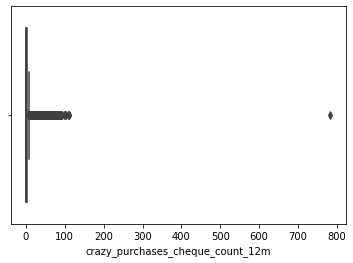

Column k_var_disc_share_6m_max
        Type  whis1.5  whis2  whis2.5  whis3
0     test_0      588    354      206    138
1     test_1      384    298      223    172
2  control_0      206    127       91     56
3  control_1      114     80       57     44


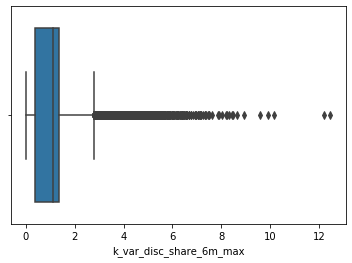

Column k_var_sku_price_6m_max
        Type  whis1.5  whis2  whis2.5  whis3
0     test_0     1113    247       54      9
1     test_1      643    168       49     18
2  control_0      413     89       23      6
3  control_1      183     52       16      4


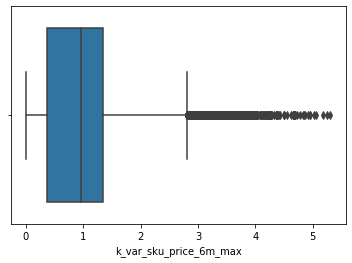

Column sale_sum_6m_sum
        Type  whis1.5  whis2  whis2.5  whis3
0     test_0    32919  24443    18387  14108
1     test_1    15619  12676    10294   8479
2  control_0    10677   7794     5865   4513
3  control_1     4831   3937     3243   2666


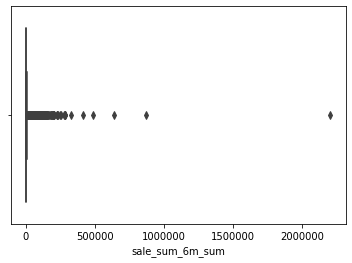

In [111]:
for key in collect_features.keys():
    print('Column', key)
    
    dataframe = {'Type' : ['test_0', 'test_1', 'control_0', 'control_1']}
    for whis in [1.5, 2, 2.5, 3]:
        IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
        sample = data[data[key] > data[key].quantile(0.75) + IQR * whis]
        sample_test = sample[sample['group'] == 'test']['response_att'].value_counts()
        sample_control = sample[sample['group'] == 'control']['response_att'].value_counts()
        
        dataframe['whis{}'.format(whis)] = [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
    
    print(pd.DataFrame(dataframe))
    sns.boxplot(data[key])
    plt.show()

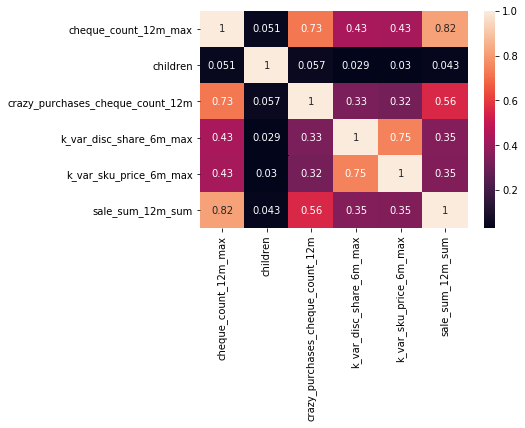

In [134]:
sns.heatmap(data[[key for key in collect_features.keys()]].corr(), annot=True)

кол-во чеков = кол-во походов в магазин

crazy-акция - по всем группам товаров

# 2. Отдельный разбор контрольной и тестовой групп
## 2.1 Тестовая группа

Разделим учатников на 2 класса в зависимости от того, поучаствовали ли они в акции, попав в тестовую группе.

In [41]:
data['response_att'].isna().any()

False

In [42]:
# Test participants who didn't take part in event
stubborn = data[data['group'] == 'test']
stubborn = stubborn[stubborn['response_att'] == 0]

# Test participants who took part in event
active = data[data['group'] == 'test']
active = active[active['response_att'] == 1]

In [43]:
stubborn.shape, active.shape

((459079, 196), (56813, 196))

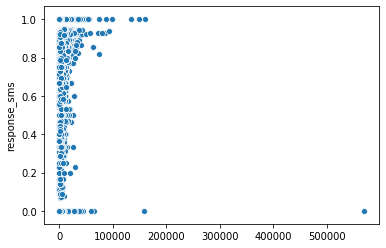

In [56]:
sales_sum = ['sale_sum_3m_g{}'.format(i) for i in [24, 26, 32, 33]]
sns.scatterplot(active[sales_sum].sum(axis=1), active['response_sms'])